In [1]:
import numpy as np
import pandas as pd

import pymoo.gradient.toolbox as anp

from pymoo.core.problem import Problem
from pymoo.util.normalization import normalize
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.util.remote import Remote

from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.selection.tournament import TournamentSelection

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.algorithms.moo.nsga2 import binary_tournament
from pymoo.algorithms.moo.nsga3 import comp_by_cv_then_random

from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.util.display.display import Display

from pymoo.problems import get_problem

from pymoo.visualization.scatter import Scatter

from pymoo.optimize import minimize

from scipy.spatial import distance

import csv
import time

In [2]:
class measure_time(Output):

    def __init__(self):
        super().__init__()
        self.x_time = Column("x_time", width=13)
        self.columns += [self.x_time]

    def update(self, algorithm):
        super().update(algorithm)
        writer.writerow([time.time() - start_time])
        self.x_time.set(time.time() - start_time)


In [3]:
class ZDT(Problem):

    def __init__(self, n_var=30, **kwargs):
        super().__init__(n_var=n_var, n_obj=2, xl=0, xu=1, vtype=float, **kwargs)

In [4]:
class ZDT1(ZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        out["F"] = anp.column_stack([f1, f2])

In [5]:
class ZDT2(ZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        f2 = g * (1 - anp.power((f1 * 1.0 / g), 2))

        out["F"] = anp.column_stack([f1, f2])

In [6]:
class ZDT3(ZDT):

    def _calc_pareto_front(self, n_points=100, flatten=True):
        regions = [[0, 0.0830015349],
                   [0.182228780, 0.2577623634],
                   [0.4093136748, 0.4538821041],
                   [0.6183967944, 0.6525117038],
                   [0.8233317983, 0.8518328654]]

        pf = []

        for r in regions:
            x1 = np.linspace(r[0], r[1], int(n_points / len(regions)))
            x2 = 1 - np.sqrt(x1) - x1 * np.sin(10 * np.pi * x1)
            pf.append(np.array([x1, x2]).T)

        if not flatten:
            pf = np.concatenate([pf[None,...] for pf in pf])
        else:
            pf = np.row_stack(pf)

        return pf

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        f2 = g * (1 - anp.power(f1 * 1.0 / g, 0.5) - (f1 * 1.0 / g) * anp.sin(10 * anp.pi * f1))

        out["F"] = anp.column_stack([f1, f2])

In [7]:
class ZDT4(ZDT):
    def __init__(self, n_var=10):
        super().__init__(n_var)
        self.xl = -5 * np.ones(self.n_var)
        self.xl[0] = 0.0
        self.xu = 5 * np.ones(self.n_var)
        self.xu[0] = 1.0
        self.func = self._evaluate

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1.0
        g += 10 * (self.n_var - 1)
        for i in range(1, self.n_var):
            g += x[:, i] * x[:, i] - 10.0 * anp.cos(4.0 * anp.pi * x[:, i])
        h = 1.0 - anp.sqrt(f1 / g)
        f2 = g * h

        out["F"] = anp.column_stack([f1, f2])

In [8]:
class ZDT5(ZDT):

    def __init__(self, m=11, n=5, normalize=True, **kwargs):
        self.m = m
        self.n = n
        self.normalize = normalize
        super().__init__(n_var=(30 + n * (m - 1)), **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = 1 + np.linspace(0, 1, n_pareto_points) * 30
        pf = np.column_stack([x, (self.m-1) / x])
        if self.normalize:
            pf = normalize(pf)
        return pf

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.astype(float)

        _x = [x[:, :30]]
        for i in range(self.m - 1):
            _x.append(x[:, 30 + i * self.n: 30 + (i + 1) * self.n])

        u = anp.column_stack([x_i.sum(axis=1) for x_i in _x])
        v = (2 + u) * (u < self.n) + 1 * (u == self.n)
        g = v[:, 1:].sum(axis=1)

        f1 = 1 + u[:, 0]
        f2 = g * (1 / f1)

        if self.normalize:
            f1 = normalize(f1, 1, 31)
            f2 = normalize(f2, (self.m-1) * 1/31, (self.m-1))

        out["F"] = anp.column_stack([f1, f2])

In [9]:
class ZDT6(ZDT):

    def __init__(self, n_var=10, **kwargs):
        super().__init__(n_var=n_var, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0.2807753191, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 1 - anp.exp(-4 * x[:, 0]) * anp.power(anp.sin(6 * anp.pi * x[:, 0]), 6)
        g = 1 + 9.0 * anp.power(anp.sum(x[:, 1:], axis=1) / (self.n_var - 1.0), 0.25)
        f2 = g * (1 - anp.power(f1 / g, 2))

        out["F"] = anp.column_stack([f1, f2])

In [10]:
NOBJ = 2
MU = 100
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=99)


algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

## ZDT 1

In [12]:
NDIM = 3
problem = ZDT1(n_var=NDIM)

In [ ]:
with open('pymoo_time_nsga2_zdt1_100_500_2_3.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt1_100_500_2_3.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
        writerFitness.writerow(fitness)

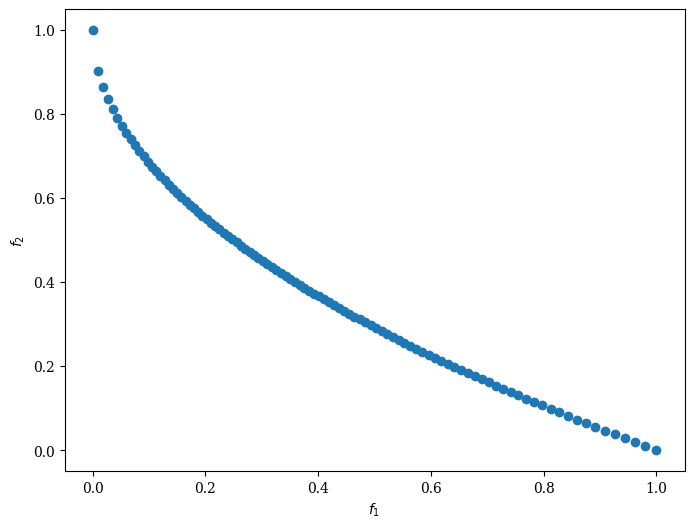

In [17]:
Scatter().add(res.F).show()

In [ ]:
with open('pymoo_time_nsga3_zdt1_100_500_2_3.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt1_100_500_2_3.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

## ZDT 2

In [19]:
NDIM = 4
problem = ZDT2(n_var=NDIM)

In [ ]:
with open('pymoo_time_nsga2_zdt2_100_500_2_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt2_100_500_2_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

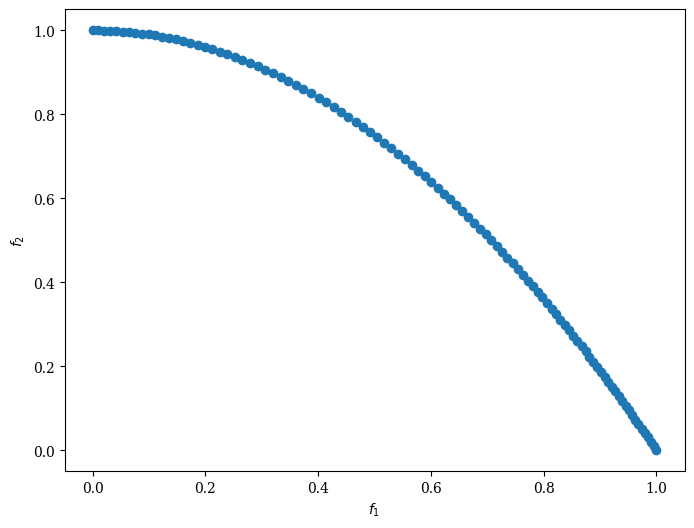

In [23]:
Scatter().add(res.F).show()

In [ ]:
with open('pymoo_time_nsga3_zdt2_100_500_2_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt2_100_500_2_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

## ZDT 3

In [25]:
NDIM = 5
problem = ZDT3(n_var=NDIM)

In [ ]:
with open('pymoo_time_nsga2_zdt3_100_500_2_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt3_100_500_2_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

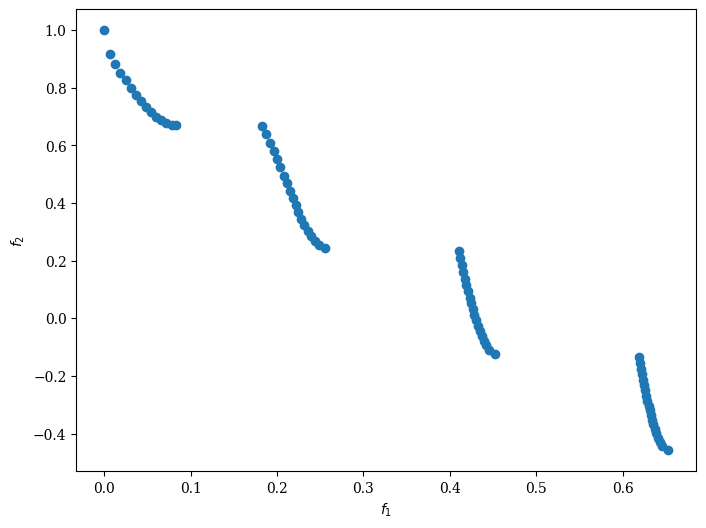

In [30]:
Scatter().add(res.F).show()

In [ ]:
with open('pymoo_time_nsga3_zdt3_100_500_2_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt3_100_500_2_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

## ZDT 4

In [31]:
NDIM = 7
problem = ZDT4(n_var=NDIM)

In [32]:
with open('pymoo_time_nsga2_zdt4_100_500_2_7.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt4_100_500_2_7.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0187220573
     2 |      200 |  0.0308024883
     3 |      300 |  0.0500214100
     4 |      400 |  0.0621919632
     5 |      500 |  0.0808951855
     6 |      600 |  0.0922067165
     7 |      700 |  0.1107692719
     8 |      800 |  0.1238913536
     9 |      900 |  0.1513221264
    10 |     1000 |  0.1811299324
    11 |     1100 |  0.2059609890
    12 |     1200 |  0.2325017452
    13 |     1300 |  0.2737870216
    14 |     1400 |  0.3028073311
    15 |     1500 |  0.3298220634
    16 |     1600 |  0.3535938263
    17 |     1700 |  0.3840181828
    18 |     1800 |  0.4023871422
    19 |     1900 |  0.4220395088
    20 |     2000 |  0.4394226074
    21 |     2100 |  0.4626421928
    22 |     2200 |  0.4795725346
    23 |     2300 |  0.4918160439
    24 |     2400 |  0.5112311840
    25 |     2500 |  0.5234758854
    26 |     2600 |  0.5419726372
    27 |     2700 |  0.5633971691
    28 |     2800 |  0.5927882195
    29 |     2

   241 |    24100 |  3.7699310780
   242 |    24200 |  3.7821583748
   243 |    24300 |  3.7942602634
   244 |    24400 |  3.8084156513
   245 |    24500 |  3.8201179504
   246 |    24600 |  3.8327639103
   247 |    24700 |  3.8442099094
   248 |    24800 |  3.8587667942
   249 |    24900 |  3.8714261055
   250 |    25000 |  3.8818747997
   251 |    25100 |  3.8939368725
   252 |    25200 |  3.9076004028
   253 |    25300 |  3.9206998348
   254 |    25400 |  3.9310016632
   255 |    25500 |  3.9444634914
   256 |    25600 |  3.9593093395
   257 |    25700 |  3.9725120068
   258 |    25800 |  3.9836668968
   259 |    25900 |  4.0000147820
   260 |    26000 |  4.0124595165
   261 |    26100 |  4.0237057209
   262 |    26200 |  4.0307571888
   263 |    26300 |  4.0483307838
   264 |    26400 |  4.0596992970
   265 |    26500 |  4.0722992420
   266 |    26600 |  4.0820233822
   267 |    26700 |  4.0958123207
   268 |    26800 |  4.1070408821
   269 |    26900 |  4.1193184853
   270 |    27

   496 |    49600 |  7.2806022167
   497 |    49700 |  7.2956962585
   498 |    49800 |  7.3082840443
   499 |    49900 |  7.3211359978
   500 |    50000 |  7.3319416046


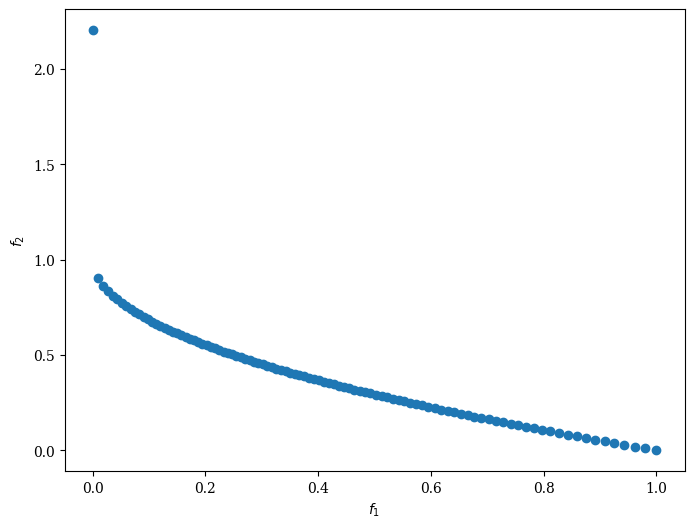

In [35]:
Scatter().add(res.F).show()

In [34]:
with open('pymoo_time_nsga3_zdt4_100_500_2_7.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt4_100_500_2_7.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0142378807
     2 |      200 |  0.0314013958
     3 |      300 |  0.0510938168
     4 |      400 |  0.0624351501
     5 |      500 |  0.0799117088
     6 |      600 |  0.1011829376
     7 |      700 |  0.1196329594
     8 |      800 |  0.1430151463
     9 |      900 |  0.1729602814
    10 |     1000 |  0.2005133629
    11 |     1100 |  0.2217557430
    12 |     1200 |  0.2753224373
    13 |     1300 |  0.3126003742
    14 |     1400 |  0.3332910538
    15 |     1500 |  0.3617713451
    16 |     1600 |  0.3925206661
    17 |     1700 |  0.4213936329
    18 |     1800 |  0.4489328861
    19 |     1900 |  0.4718048573
    20 |     2000 |  0.5015258789
    21 |     2100 |  0.5204236507
    22 |     2200 |  0.5409107208
    23 |     2300 |  0.5608689785
    24 |     2400 |  0.5810675621
    25 |     2500 |  0.6003739834
    26 |     2600 |  0.6210558414
    27 |     2700 |  0.6413407326
    28 |     2800 |  0.6610205173
    29 |     2

   242 |    24200 |  7.3377382755
   243 |    24300 |  7.3809280396
   244 |    24400 |  7.4177958965
   245 |    24500 |  7.4493339062
   246 |    24600 |  7.4798965454
   247 |    24700 |  7.5075776577
   248 |    24800 |  7.5409085751
   249 |    24900 |  7.5932121277
   250 |    25000 |  7.6297597885
   251 |    25100 |  7.6615631580
   252 |    25200 |  7.6918778419
   253 |    25300 |  7.7219424248
   254 |    25400 |  7.7526259422
   255 |    25500 |  7.7850716114
   256 |    25600 |  7.8274898529
   257 |    25700 |  7.8621828556
   258 |    25800 |  7.8977944851
   259 |    25900 |  7.9278161526
   260 |    26000 |  7.9595384598
   261 |    26100 |  7.9904420376
   262 |    26200 |  8.0199296474
   263 |    26300 |  8.0581891537
   264 |    26400 |  8.0926105976
   265 |    26500 |  8.1275575161
   266 |    26600 |  8.1615717411
   267 |    26700 |  8.2010545731
   268 |    26800 |  8.2308154106
   269 |    26900 |  8.2623500824
   270 |    27000 |  8.3114559650
   271 |    27

   488 |    48800 |  1.479644E+01
   489 |    48900 |  1.481578E+01
   490 |    49000 |  1.483902E+01
   491 |    49100 |  1.485970E+01
   492 |    49200 |  1.487965E+01
   493 |    49300 |  1.489862E+01
   494 |    49400 |  1.492061E+01
   495 |    49500 |  1.494849E+01
   496 |    49600 |  1.497994E+01
   497 |    49700 |  1.501540E+01
   498 |    49800 |  1.505655E+01
   499 |    49900 |  1.509406E+01
   500 |    50000 |  1.512606E+01


## ZDT 5

In [37]:
problem = ZDT5()
algorithm_nsga2_bin = NSGA2(pop_size=MU, 
                      sampling=BinaryRandomSampling(),
                      selection=TournamentSelection(func_comp=binary_tournament),
                      crossover=TwoPointCrossover(),
                      mutation=BitflipMutation(),
                      eliminate_duplicates=False)

algorithm_nsga3_bin = NSGA3(pop_size=MU, 
                            sampling=BinaryRandomSampling(), 
                            selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                            crossover=TwoPointCrossover(),
                            mutation=BitflipMutation(),
                            ref_dirs=ref_dirs,
                            eliminate_duplicates=False)

In [ ]:
with open('pymoo_time_nsga2_zdt5_100_500_2_80.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt5_100_500_2_80.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2_bin, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

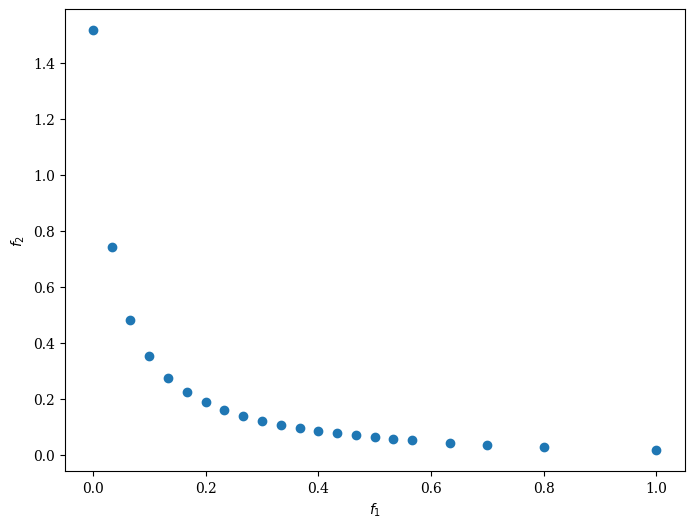

In [41]:
Scatter().add(res.F).show()

In [ ]:
with open('pymoo_time_nsga3_zdt5_100_500_2_80.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt5_100_500_2_80.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3_bin, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

## ZDT 6

In [42]:
NDIM = 10
problem = ZDT6(n_var=NDIM)

In [ ]:
with open('pymoo_time_nsga2_zdt6_100_500_2_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt6_100_500_2_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', 1000), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

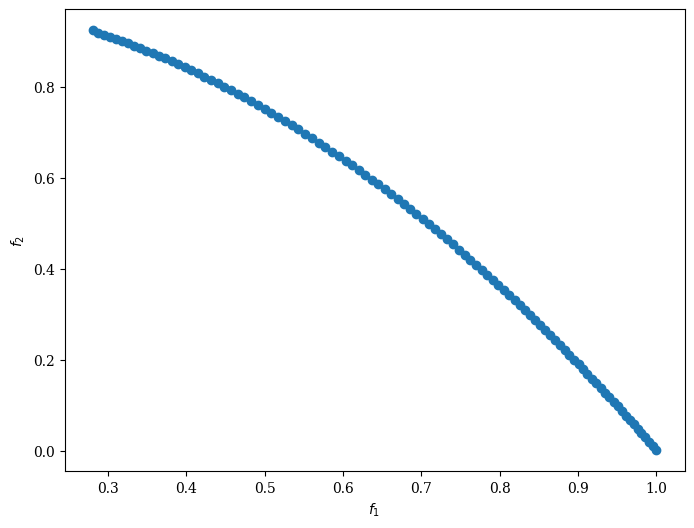

In [46]:
Scatter().add(res.F).show()

In [ ]:
with open('pymoo_time_nsga3_zdt6_100_500_2_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt6_100_500_2_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', 1000), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)